In [12]:
import os
import glob
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

Total de arquivos .nii.gz encontrados: 373
Exibindo 15 imagens aleatórias (com lógica 2D/3D)...


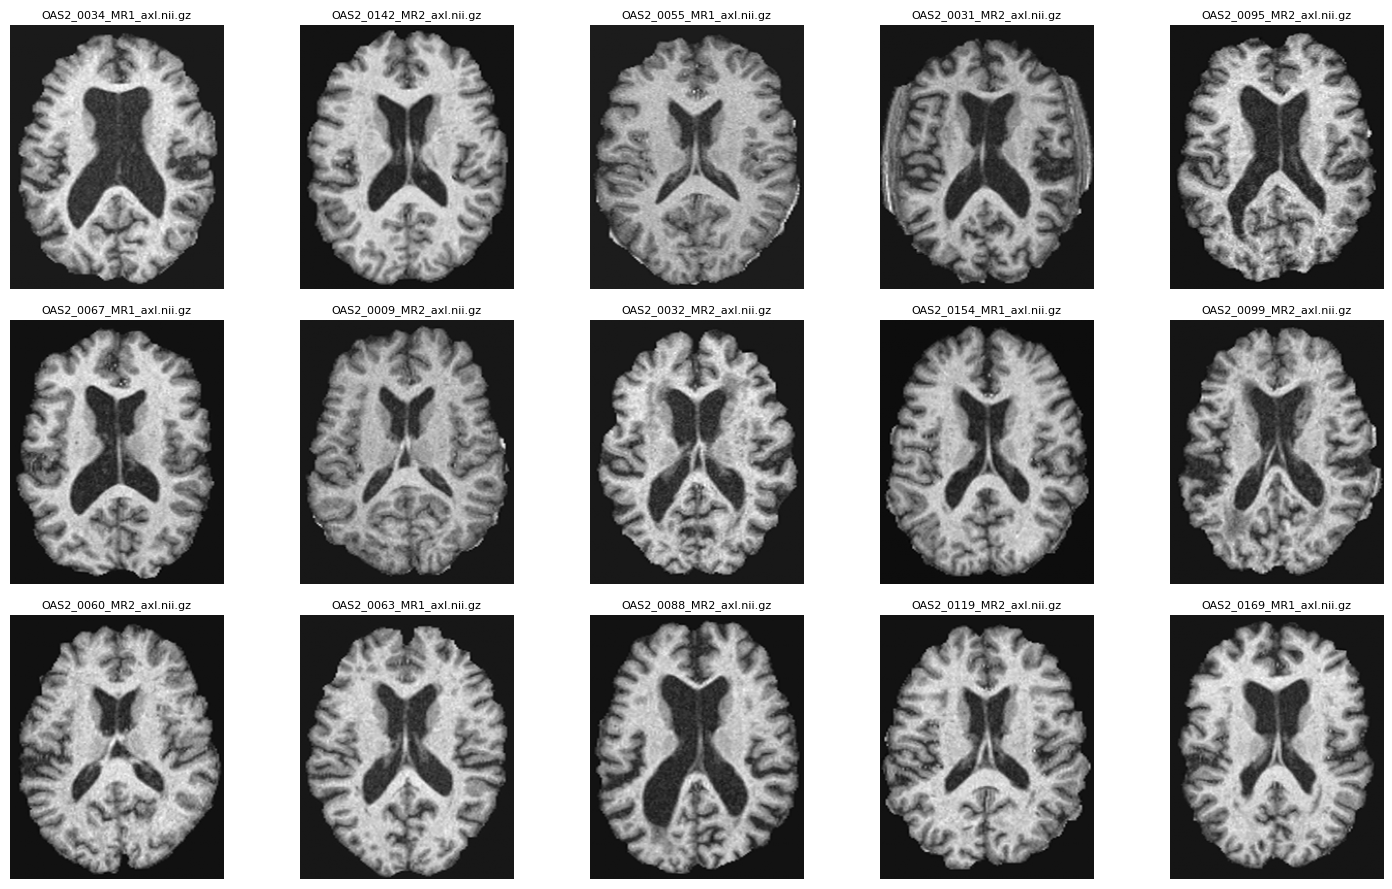

In [15]:
# 1. Definir o diretório dos dados (com o caminho corrigido)
data_dir = '../database/axl/'

# 2. Encontrar todos os arquivos .nii.gz no diretório
all_files = glob.glob(os.path.join(data_dir, '*.nii.gz'))

if not all_files:
    print(f"Nenhum arquivo .nii.gz encontrado em {data_dir}")
else:
    print(f"Total de arquivos .nii.gz encontrados: {len(all_files)}")

    # 3. Definir quantas imagens aleatórias mostrar
    num_to_show = 15
    
    # Garante que não vamos tentar pegar mais arquivos do que existem
    num_to_show = min(num_to_show, len(all_files))
    
    # 4. Selecionar os arquivos aleatoriamente
    random_files = random.sample(all_files, num_to_show)
    
    # 5. Configurar o grid da visualização (3 linhas, 5 colunas)
    rows = 3
    cols = 5
    
    plt.figure(figsize=(15, 9)) # Ajuste o tamanho conforme necessário
    
    print(f"Exibindo {num_to_show} imagens aleatórias (com lógica 2D/3D)...")
    
    # 6. Loop para carregar e plotar cada imagem
    for i, file_path in enumerate(random_files):
        try:
            # Carrega a imagem NIfTI
            nii_img = nib.load(file_path)
            
            # Pega os dados da imagem como um array NumPy
            img_data = nii_img.get_fdata()
            
            slice_data = None # Inicializa a variável do corte
            
            # --- INÍCIO DA CORREÇÃO ---
            # Verificamos o número de dimensões do array de dados
            
            if img_data.ndim == 2:
                # Caso 1: A imagem JÁ É 2D.
                slice_data = img_data
                
            elif img_data.ndim == 3:
                # Caso 2: A imagem é 3D (o que esperávamos antes).
                # Pegamos o corte do meio no eixo Z (índice 2).
                middle_slice_idx = img_data.shape[2] // 2
                slice_data = img_data[:, :, middle_slice_idx]
            
            elif img_data.ndim == 4:
                # Caso 3: Bônus - se for 4D (ex: 3D + tempo).
                # Pega o corte do meio (eixo Z) do primeiro volume de tempo (eixo T).
                middle_slice_idx = img_data.shape[2] // 2
                slice_data = img_data[:, :, middle_slice_idx, 0]
                
            else:
                # Se não for 2D, 3D ou 4D, não sabemos o que fazer.
                raise ValueError(f"Dimensões não esperadas: {img_data.ndim} (shape: {img_data.shape})")
            
            # --- FIM DA CORREÇÃO ---

            # Prepara o subplot
            plt.subplot(rows, cols, i + 1)
            
            # Mostra a imagem
            plt.imshow(np.rot90(slice_data), cmap='gray')
            plt.title(os.path.basename(file_path), fontsize=8)
            plt.axis('off') # Remove os eixos x/y
        
        except Exception as e:
            # Caso algum arquivo dê erro ao carregar
            # Usamos os.path.basename para não poluir o título com o caminho todo
            print(f"Erro ao processar {os.path.basename(file_path)}: {e}")
            plt.subplot(rows, cols, i + 1)
            plt.title(f"Erro: {os.path.basename(file_path)}", fontsize=8, color='red')
            plt.axis('off')

    plt.tight_layout() # Ajusta o espaçamento
    plt.show()